In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

Executing <Task pending name='Task-4' coro=<Kernel.dispatch_queue() running at /Users/wmac/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py:524> wait_for=<Future pending cb=[Task.task_wakeup()] created at /Users/wmac/Library/Python/3.12/lib/python/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/wmac/Library/Python/3.12/lib/python/site-packages/tornado/ioloop.py:685] created at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/tasks.py:685> took 0.721 seconds


In [2]:
data = []
df_row = {}
LAST_CORNER = 2377

with open('linpots.json', 'r') as f:
    for line in tqdm(f.readlines()):
        row = eval(line.strip())

        if df_row == {}:
          df_row['ts'] = row['ts']

        corner = row['id']
        df_row[corner] = row['meter']

        if corner == LAST_CORNER:
          data.append(df_row)
          df_row = {}

df = pd.DataFrame(data)
df.columns = ['ts', 'FL', 'FR', 'RL', 'RR']
df['ts'] -= df['ts'].min()
# df['ts'] = pd.to_datetime(df['ts'])
df

100%|██████████| 537514/537514 [00:25<00:00, 20731.70it/s]
Executing <Handle IOLoop._run_callback(functools.par... 0x11f1080e0>)) created at /Users/wmac/Library/Python/3.12/lib/python/site-packages/tornado/platform/asyncio.py:225> took 0.130 seconds


,ts,FL,FR,RL,RR
0,0.000000,0.495614,0.491917,0.428815,0.458122
1,0.188712,0.495614,0.491917,0.428815,0.458122
2,0.283078,0.495614,0.491917,0.428815,0.458122
3,0.372358,0.495614,0.491917,0.428815,0.458122
4,0.445120,0.495614,0.491917,0.428947,0.458254
...,...,...,...,...,...
134370,11831.305817,0.463403,0.474624,0.453370,0.457198
134371,11831.368938,0.463403,0.474492,0.453370,0.457198
134372,11831.429513,0.463403,0.474624,0.453370,0.457198
134373,11831.490478,0.463403,0.474624,0.453370,0.457198


Executing <Task pending name='Task-4' coro=<Kernel.dispatch_queue() running at /Users/wmac/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py:524> wait_for=<Future pending cb=[Task.task_wakeup()] created at /Users/wmac/Library/Python/3.12/lib/python/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/wmac/Library/Python/3.12/lib/python/site-packages/tornado/ioloop.py:685] created at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/tasks.py:685> took 26.484 seconds


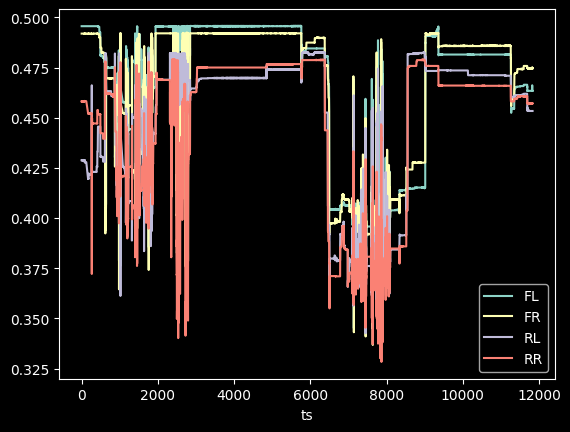

In [3]:
df.plot(x='ts')
plt.show()

In [6]:
df['ts'].max() / 60 / 60 # Hours?

3.2865451182921728

In [7]:
df['ts_delta'] = df['ts'].diff()

df['FL_vel'] = df['FL'].diff() / df['ts_delta']
df['FR_vel'] = df['FR'].diff() / df['ts_delta']
df['RL_vel'] = df['RL'].diff() / df['ts_delta']
df['RR_vel'] = df['RR'].diff() / df['ts_delta']

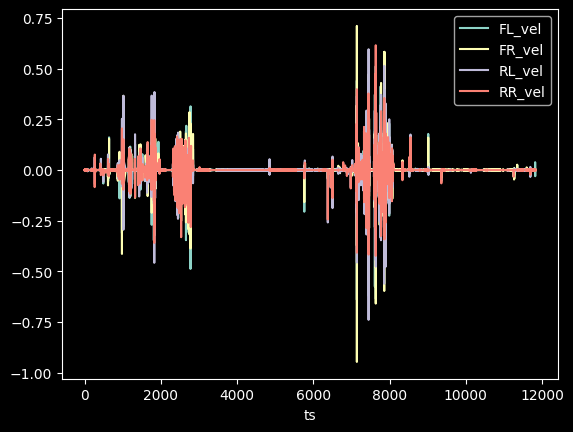

In [8]:
df.plot(x='ts', y=['FL_vel', 'FR_vel', 'RL_vel', 'RR_vel'])
plt.show()

In [10]:
df.describe()

,ts,FL,FR,RL,RR,ts_delta,FL_vel,FR_vel,RL_vel,RR_vel
count,134375.000000,134375.000000,134375.000000,134375.000000,134375.000000,134374.000000,134374.000000,134374.000000,134374.000000,134374.000000
mean,6275.690687,0.465461,0.464149,0.449459,0.447118,0.088049,-0.000002,0.000008,-0.000005,0.000009
std,3247.202687,0.036232,0.036855,0.036093,0.039007,0.742277,0.012450,0.014094,0.013788,0.011142
min,0.000000,0.345119,0.336802,0.340102,0.328353,0.049643,-0.640219,-0.946633,-0.739229,-0.423375
25%,3775.584542,0.440036,0.427627,0.428155,0.425515,0.071400,0.000000,0.000000,0.000000,0.000000
50%,6302.271784,0.481488,0.485713,0.469739,0.465911,0.077328,0.000000,0.000000,0.000000,0.000000
75%,8921.799484,0.495614,0.492050,0.473568,0.475020,0.085026,0.000000,0.000000,0.000000,0.000000
max,11831.562426,0.495746,0.492446,0.482413,0.479244,180.459355,0.511912,0.710920,0.595840,0.615603


Executing <Task pending name='Task-4' coro=<Kernel.dispatch_queue() running at /Users/wmac/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelbase.py:524> wait_for=<Future pending cb=[Task.task_wakeup()] created at /Users/wmac/Library/Python/3.12/lib/python/site-packages/tornado/queues.py:248> cb=[IOLoop.add_future.<locals>.<lambda>() at /Users/wmac/Library/Python/3.12/lib/python/site-packages/tornado/ioloop.py:685] created at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/tasks.py:685> took 0.185 seconds
